Using kernel `conda_pytorch_latest_p36`

In [1]:
import torch

In [2]:
from pathlib import Path
import os
import random

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [46]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
classes = [
    'Agricolture',
    'Cross',
    'Education',
    'Food Security',
    'Health',
    'Livelihoods',
    'Logistics',
    'Nutrition',
    'Protection',
    'Shelter',
    'Wash'
]

## Sagemaker Prep

In [5]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(
    role
)  # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'sagemaker-stefano'
print(bucket)
prefix = "blazingtext/supervised"  # Replace with the prefix under which you want to store the data if needed


arn:aws:iam::519887312542:role/AmazonSageMakerFullAccessRole
sagemaker-stefano


## Data

### Data preparation

In [6]:
data = Path('data_prep/final_data/en/')
raw = pd.read_csv('data_prep/data/entries_raw.csv')

train = pd.read_csv(data / 'sentences_en_train.csv')
test = pd.read_csv(data / 'sentences_en_test.csv')

In [7]:
def preprocessing(df, train):
    relevant_train = df[df.is_relevant == 1]
    relevant_train.sector_ids = relevant_train.sector_ids.apply(eval)
    relevant_train = relevant_train[relevant_train.sector_ids.apply(len) > 0]
    
    relevant_train['tokenized_sentence'] = relevant_train.sentence_text.apply(
        lambda x: nltk.word_tokenize(x.lower())
    )
    relevant_train['file_content'] = relevant_train.apply(
        lambda x: {"source":' '.join(x.tokenized_sentence), "label":x.sector_ids}, axis=1
    )
        
    return relevant_train

In [8]:
train_df = preprocessing(train, True)
test_df = preprocessing(test, False)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
with open('immap.train', 'w') as f:
    for line in train_df.file_content:
        f.write(json.dumps(line) + '\n')
        
with open('immap.validation', 'w') as f:
    for line in test_df.file_content:
        f.write(json.dumps(line) + '\n')

### Bucket upload

In [10]:
train_channel = prefix + "/train/immap.train"
validation_channel = prefix + "/validation/immap.validation"

sess.upload_data(path="immap.train", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="immap.validation", bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)

s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

## Train

In [11]:
region_name = boto3.Session().region_name

In [12]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print("Using SageMaker BlazingText container: {} ({})".format(container, region_name))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [13]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    hyperparameters={
        "mode": "supervised",
        "epochs": 4,
        "min_count": 2,
        "learning_rate": 0.05,
        "vector_dim": 10,
#         "early_stopping": False,
        "patience": 4,
#         "min_epochs": 5,
#         "word_ngrams": 2,
    },
)

In [14]:
# Create a train data channel with S3_data_type as 'AugmentedManifestFile' and attribute names.
# train_data = sagemaker.session.s3_input(
#     your_augmented_manifest_file,
#     distribution='FullyReplicated',
#     content_type='application/x-recordio',
#     s3_data_type='AugmentedManifestFile',
#     attribute_names=['source-ref', 'annotations'],
#     input_mode='Pipe',
#     record_wrapping='RecordIO'
# )

In [15]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="AugmentedManifestFile",
    input_mode='Pipe',
    attribute_names=['source', 'label'],
    record_wrapping='RecordIO',
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="AugmentedManifestFile",
    input_mode='Pipe',
    attribute_names=['source', 'label'],
    record_wrapping='RecordIO',
)
data_channels = {"train": train_data, "validation": validation_data}

In [ ]:
bt_model.fit(inputs=data_channels, logs=True)

2021-05-17 15:59:25 Starting - Starting the training job...
2021-05-17 15:59:49 Starting - Launching requested ML instancesProfilerReport-1621267165: InProgress
..

In [17]:
1

1

In [18]:
from sagemaker.serializers import JSONSerializer

text_classifier = bt_model.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
)


---------------!

In [61]:
sentences = list(test_df.sentence_text)

# using the same nltk tokenizer that we used during data preparation for training
tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances": tokenized_sentences, "configuration": {"k": 5}}

response = text_classifier.predict(payload)

predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint blazingtext-2021-05-17-16-07-02-280 of account 519887312542 not found.

In [25]:
t = test_df.copy()

In [57]:
a = []
thresh = 0.05
for pred in predictions:
    labels = [int(x.replace('__label__', '')) for x, y in zip(pred['label'], pred['prob']) if y > thresh]
    a.append(labels)

In [58]:
t['preds'] = a

In [59]:
indexes = []
recalls = []
precisions = []
f1_scores = []

for i, class_ in enumerate(classes):
    class_preds = [1 if i in x else 0 for x in t.preds]
    class_targets = [1 if i in x else 0 for x in t.sector_ids]

    indexes.append(class_)
    precisions.append(precision_score(class_targets, class_preds))
    recalls.append(recall_score(class_targets, class_preds))    
    f1_scores.append(f1_score(class_targets, class_preds))        


all_metrics = pd.DataFrame(
    {
        'class': indexes,
        'recall': recalls,
        'precision': precisions,
        'f1_score': f1_scores
    }
).set_index('class', drop=True)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='class'>

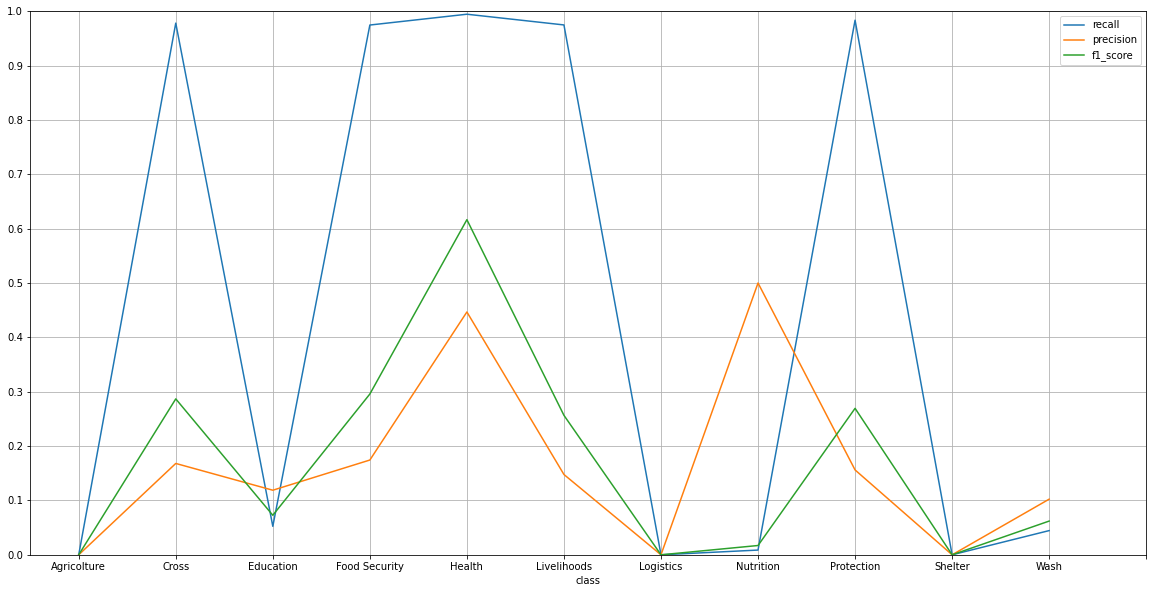

In [60]:
all_metrics.plot(
    figsize=(20, 10), xticks=range(12), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True
)

In [49]:
t

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids,tokenized_sentence,file_content,preds
0,51787,1,"al., 2014; Dell, Jones, and Olken, 2014).",1,[0],"[al., ,, 2014, ;, dell, ,, jones, ,, and, olke...","{'source': 'al. , 2014 ; dell , jones , and ol...",[4]
1,51657,15,Many orphaned youth live in poverty and have l...,1,"[2, 5]","[many, orphaned, youth, live, in, poverty, and...",{'source': 'many orphaned youth live in povert...,"[4, 8, 1]"
2,51657,17,Other youth live in shelters or on the streets.,1,"[2, 5]","[other, youth, live, in, shelters, or, on, the...",{'source': 'other youth live in shelters or on...,"[4, 8, 1, 3, 5]"
3,51542,0,WFP Colombia Country Brief December 2020 Opera...,1,[3],"[wfp, colombia, country, brief, december, 2020...",{'source': 'wfp colombia country brief decembe...,"[4, 8, 1, 3]"
4,51542,2,Colombia has also become the largest host for ...,1,[3],"[colombia, has, also, become, the, largest, ho...",{'source': 'colombia has also become the large...,"[4, 8, 1, 3]"
...,...,...,...,...,...,...,...,...
17358,36453,56,The UN estimates that approximately 90 percent...,1,"[5, 7]","[the, un, estimates, that, approximately, 90, ...",{'source': 'the un estimates that approximatel...,"[4, 8, 1, 3]"
17670,36069,313,"In the reporting period, UNICEF provided soap ...",1,"[3, 10]","[in, the, reporting, period, ,, unicef, provid...","{'source': 'in the reporting period , unicef p...","[4, 8, 3, 1, 5]"
17838,36039,99,"In addition, UNICEF report that nutrition acti...",1,"[2, 7]","[in, addition, ,, unicef, report, that, nutrit...","{'source': 'in addition , unicef report that n...","[4, 8, 1, 3]"
17839,36039,100,Education activities has also increased in rec...,1,"[2, 7]","[education, activities, has, also, increased, ...",{'source': 'education activities has also incr...,"[4, 8, 3, 1, 5]"
